In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import mglearn
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix,precision_score,recall_score,f1_score,
    roc_curve,roc_auc_score,precision_recall_curve,accuracy_score,classification_report)

In [34]:
def read_xyz(fileName):
    
    xyz_coordinates = [] #put xyz in an array
    
    with open(fileName,"r") as file:
        for line_number,line in enumerate(file):
            x,y,z = line.split()
            
            xyz_coordinates.append([int(x),int(y),float(z)])
    return xyz_coordinates

In [35]:
groundwater_map = read_xyz("GRW_MBS_50m.xyz")

In [36]:
#display in dataframe 
#add cplumns of name
my_array = np.array(groundwater_map)

df = pd.DataFrame(my_array, columns = ['XKoordinat','YKoordinat','Depth'])

In [37]:
data = pd.read_csv("Energi_Viborg_Dandas_data.csv")

#drop columns not needed after asking the company about the meaning of these features

columns_to_be_removed = [ 'mslink','LedningID','Dobbeltled','EjerKompon','SystemKode','KategoriAf','DatoUdf']
data=data.drop(columns_to_be_removed,axis='columns')

# in the column DatoSaneri is the date of repairing and if there is no date it means it is not repaired

data['DatoSaneri'].fillna(0, inplace=True)

In [38]:
# take only the pipes that are broken(by TV insection) now and the repaired ones

data_with_TVObsAndSaneri = data[data['TVObsKode'].isin([1]) | data['DatoSaneri'] > 0]

In [39]:
def get_matched_depth(select_x,select_y):
#     select_x = data['XKoordinat']
#     select_y = data['YKoordinat']
    #select_y = data.loc[data['XKoordinat'] == select_x]['YKoordinat'].values[0]
    length = data_with_TVObsAndSaneri.loc[data_with_TVObsAndSaneri['XKoordinat'] == select_x]['Laengde'].values[0]
    angle = data_with_TVObsAndSaneri.loc[data_with_TVObsAndSaneri['XKoordinat'] == select_x]['Fald'].values[0]
#     length=data['Laengde']
#     angle = data['Fald']
    #calculate another point by length:
    end_x = select_x+ (length * np.cos(angle))
    end_y = select_y+ (length * np.sin(angle))
    if(end_x > select_x):
        max_x=end_x
        min_x=select_x
    else:
        min_x=end_x
        max_x=select_x   
    if(end_y > select_y):
        max_y=end_y
        min_y=select_y
    else:
        min_y=end_y
        max_y=select_y   


    matched_depth_col = df.loc[(df['XKoordinat'] <= max_x)&(df['XKoordinat'] >= min_x)
    &(df['YKoordinat'] <= max_y)&(df['YKoordinat'] >= min_y)]['Depth']
    #test if there is a value
    if(matched_depth_col.size > 0):
        matched_depth = matched_depth_col.values[0]
    else:
        matched_depth = np.NaN
    
    return matched_depth

In [40]:
def add_depth(datacopy):
    select_x = datacopy['XKoordinat']
    select_y = datacopy['YKoordinat']
    return get_matched_depth(select_x,select_y)
data_with_TVObsAndSaneri['Depth'] = data_with_TVObsAndSaneri.apply(add_depth,axis =1)
data_with_TVObsAndSaneri    
        

,ID,XKoordinat,YKoordinat,fra_kote,til_kote,Laengde,Fald,DiameterIn,MaterialeK,anlag_aar,TransportK,Funktionsk,TVObsKode,DatoOprett,DatoOpdate,DatoSaneri,Depth
36,87810,529911.05,6252443.83,34.720000,33.480000,64.88,19.112207,300.0,1.0,1939.0,1,0,0.0,2010,2014,1997.0,NaN
42,87832,530405.37,6252578.04,39.460000,39.160000,91.75,3.269755,400.0,1.0,1939.0,1,0,1.0,2010,2014,0.0,2.314121
43,87834,530493.05,6252579.67,39.710000,39.480000,87.69,2.622876,300.0,1.0,1939.0,1,0,1.0,2010,2014,0.0,NaN
64,87901,530791.62,6252572.03,40.550000,40.080000,52.11,9.019382,250.0,1.0,1945.0,1,0,1.0,2010,2014,0.0,4.478954
65,87903,530857.05,6252552.13,40.380000,40.550000,68.39,-2.485744,250.0,1.0,1945.0,1,0,1.0,2010,2014,0.0,5.462685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23957,222195,500582.01,6260561.72,11.940000,10.550000,60.32,23.043767,350.0,1.0,1968.0,1,0,1.0,2018,2018,0.0,9.960063
24062,222448,544401.67,6256588.02,25.720000,22.820000,44.37,65.359477,160.0,4.0,2017.0,1,0,1.0,2018,2018,0.0,NaN
24073,222942,530696.61,6245426.58,28.490000,27.730000,84.29,9.016491,200.0,1.0,1995.0,1,0,1.0,2018,2018,0.0,NaN
24090,222967,530819.00,6245345.46,27.162706,27.902884,18.82,-39.329328,315.0,4.0,1965.0,1,0,1.0,2018,2018,0.0,NaN


In [41]:
data_with_TVObsAndSaneri_Groundwater = data_with_TVObsAndSaneri.dropna()

In [42]:
data_not_broken = data[~data['TVObsKode'].isin([0]) | data['DatoSaneri'] == 0]
data_not_broken = data_not_broken.sample(n=4000) 

In [43]:
def get_matched_depth_unbroken(select_x,select_y):
#     select_x = data['XKoordinat']
#     select_y = data['YKoordinat']
    #select_y = data.loc[data['XKoordinat'] == select_x]['YKoordinat'].values[0]
    length = data_not_broken.loc[data_not_broken['XKoordinat'] == select_x]['Laengde'].values[0]
    angle = data_not_broken.loc[data_not_broken['XKoordinat'] == select_x]['Fald'].values[0]
#     length=data['Laengde']
#     angle = data['Fald']
    #calculate another point by length:
    end_x = select_x+ (length * np.cos(angle))
    end_y = select_y+ (length * np.sin(angle))
    if(end_x > select_x):
        max_x=end_x
        min_x=select_x
    else:
        min_x=end_x
        max_x=select_x   
    if(end_y > select_y):
        max_y=end_y
        min_y=select_y
    else:
        min_y=end_y
        max_y=select_y   


    matched_depth_col = df.loc[(df['XKoordinat'] <= max_x)&(df['XKoordinat'] >= min_x)
    &(df['YKoordinat'] <= max_y)&(df['YKoordinat'] >= min_y)]['Depth']
    #test if there is a value
    if(matched_depth_col.size > 0):
        matched_depth = matched_depth_col.values[0]
    else:
        matched_depth = np.NaN
    
    return matched_depth

In [44]:
def add_depth_unbroken(datacopy):
    select_x = datacopy['XKoordinat']
    select_y = datacopy['YKoordinat']
    return get_matched_depth_unbroken(select_x,select_y)
data_not_broken['Depth'] = data_not_broken.apply(add_depth_unbroken,axis =1)
        

In [45]:
data_not_broken_Groundwater = data_not_broken.dropna()
data_not_broken_Groundwater =data_not_broken_Groundwater.sample(n=619)

In [46]:
frames = [data_not_broken_Groundwater,data_with_TVObsAndSaneri_Groundwater]
data = pd.concat(frames)

In [47]:
datacopy = data


# add  age column

#get current year
from datetime import date
now = date.today().year


def age_df(datacopy):

    if (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] > 0) :
        return (now - datacopy['DatoSaneri'])
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri']== 0):
        return (now - datacopy['anlag_aar'])
    elif (datacopy['TVObsKode'] == 0) and (datacopy['DatoSaneri'] > 0):
        return (now - datacopy['DatoSaneri'])
    elif (datacopy['TVObsKode']== 0) and (datacopy['DatoSaneri']== 0):
        return (now - datacopy['anlag_aar'])

datacopy['Age'] = datacopy.apply(age_df, axis = 1)

In [48]:
# add a column 'PipeStatus'
# 1 as broken and 0 as not broken

def broken_df(datacopy):

    if (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] < (datacopy['DatoOpdate'])) and (datacopy['DatoSaneri'] != 0):
        return 1
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] >= (datacopy['DatoOpdate'])) and (datacopy['DatoSaneri'] != 0):
        return 0
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri']== 0):
        return 1
    elif (datacopy['TVObsKode'] == 0) and (datacopy['DatoSaneri'] > 0):
        return 0
    elif (datacopy['TVObsKode']== 0) and (datacopy['DatoSaneri']== 0):
        return 0

datacopy['PipeStatus'] = datacopy.apply(broken_df, axis = 1)

In [49]:
# datacopy = datacopy.sample(n=22) 
# datacopy

In [50]:
# data_fs= np.where(np.isnan(datacopy))
# data_fs
# row = datacopy.iloc[369] #index=1 => second row
# print(row)

In [51]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(datacopy.shape[0]))
datacopy = datacopy.dropna()
print("Number of rows after removing NaNs: {}".format(datacopy.shape[0]))

Number of rows before removing NaNs: 1238
Number of rows after removing NaNs: 1238


In [52]:
#drop columns not needed after adding new features

columns_to_be_removed = ['DatoOprett', 'DatoOpdate']
datacopy=datacopy.drop(columns_to_be_removed,axis='columns')
datacopy[0:-1]

,ID,XKoordinat,YKoordinat,fra_kote,til_kote,Laengde,Fald,DiameterIn,MaterialeK,anlag_aar,TransportK,Funktionsk,TVObsKode,DatoSaneri,Depth,Age,PipeStatus
17514,190409,541611.83,6246880.03,15.30,14.68,52.68,11.769172,300.0,1.0,1980.0,1,10,0.0,0.0,1.795532,41.0,0
1129,93328,543573.86,6261632.53,47.85,47.07,55.45,14.066727,200.0,1.0,1964.0,1,0,0.0,0.0,17.932590,57.0,0
11342,147568,510871.21,6241105.19,38.68,38.61,90.88,0.770246,500.0,1.0,1978.0,1,0,0.0,0.0,4.389423,43.0,0
9537,138300,527968.97,6257287.86,52.93,52.47,25.12,18.312102,150.0,4.0,1991.0,1,0,0.0,0.0,34.266228,30.0,0
22255,214045,500835.31,6255778.60,15.33,14.79,96.58,5.591220,300.0,1.0,1985.0,1,0,0.0,0.0,3.867814,36.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23825,221075,505295.19,6253688.34,41.00,40.24,77.12,9.854772,200.0,1.0,1979.0,1,0,1.0,0.0,14.129904,42.0,1
23835,221099,505487.19,6253719.27,40.77,40.36,57.64,7.113116,200.0,1.0,1979.0,1,0,1.0,0.0,14.236778,42.0,1
23838,221112,505553.82,6253730.01,41.26,40.78,67.49,7.112165,200.0,1.0,1979.0,1,0,1.0,0.0,15.404106,42.0,1
23841,221115,505234.88,6253724.12,42.49,41.53,109.15,8.795236,315.0,4.0,1992.0,1,0,1.0,0.0,16.049837,29.0,1


In [57]:

# creating features set and target

columns_to_be_removed = ['PipeStatus','TVObsKode','YKoordinat','XKoordinat', 'ID']
data_features= datacopy.drop(columns_to_be_removed,axis='columns')
columns_to_be_removed = ['fra_kote','til_kote', 'Laengde','Fald','DiameterIn','MaterialeK',
                         'anlag_aar','TransportK','Funktionsk','DatoSaneri','Age', 'Depth',
                         'TVObsKode','YKoordinat','XKoordinat','ID']
data_target=datacopy.drop(columns_to_be_removed,axis='columns')


In [54]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(data.shape[0]))
data = data.dropna()
print("Number of rows after removing NaNs: {}".format(data.shape[0]))

Number of rows before removing NaNs: 1238
Number of rows after removing NaNs: 1238


In [58]:
data_target

,PipeStatus
17514,0
1129,0
11342,0
9537,0
22255,0
...,...
23835,1
23838,1
23841,1
23957,1


# Tuning parameters with test-set split and grid search cross validation

In [69]:
# Divide the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_target, stratify=data_target, random_state=42)

In [70]:
#List Hyperparameters that we want to tune by cross validation

max_depth = [3,4,5,6,7,8,9,10,20,30,40,50,60]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2','auto']

#Convert to dictionary
hyperparameters = dict(max_depth=max_depth, max_features=max_features, criterion=criterion)

#Create new decision tre object
dec_tree = DecisionTreeClassifier()

#Use GridSearch
clf = GridSearchCV(dec_tree, hyperparameters, cv=5,return_train_score=True, scoring="recall")

#Fit the model
best_model = clf.fit(X_train, y_train)

#Print The value of best Hyperparameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
    
print("Accuracy on training set: {:.3f}".format(best_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(best_model.score(X_test, y_test)))

Best max_depth: 60
Best max_features: sqrt
Best criterion: gini
Accuracy on training set: 1.000
Accuracy on test set: 0.403


In [71]:
#Create forest Object.
a = best_model.best_estimator_.get_params()['max_depth']
b = best_model.best_estimator_.get_params()['max_features']
c = best_model.best_estimator_.get_params()['criterion']
dec_tree = DecisionTreeClassifier(criterion= c, max_depth= a, max_features= b, random_state=0)

#Create x and y variables.
x = data_features
y = data_target

#Split data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

#Training the model.
dec_tree.fit(X_train, y_train)

#Predict test data set.
y_pred = dec_tree.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       239
           1       0.42      0.49      0.45        71

    accuracy                           0.73       310
   macro avg       0.63      0.65      0.64       310
weighted avg       0.75      0.73      0.74       310



0.6460604631975957

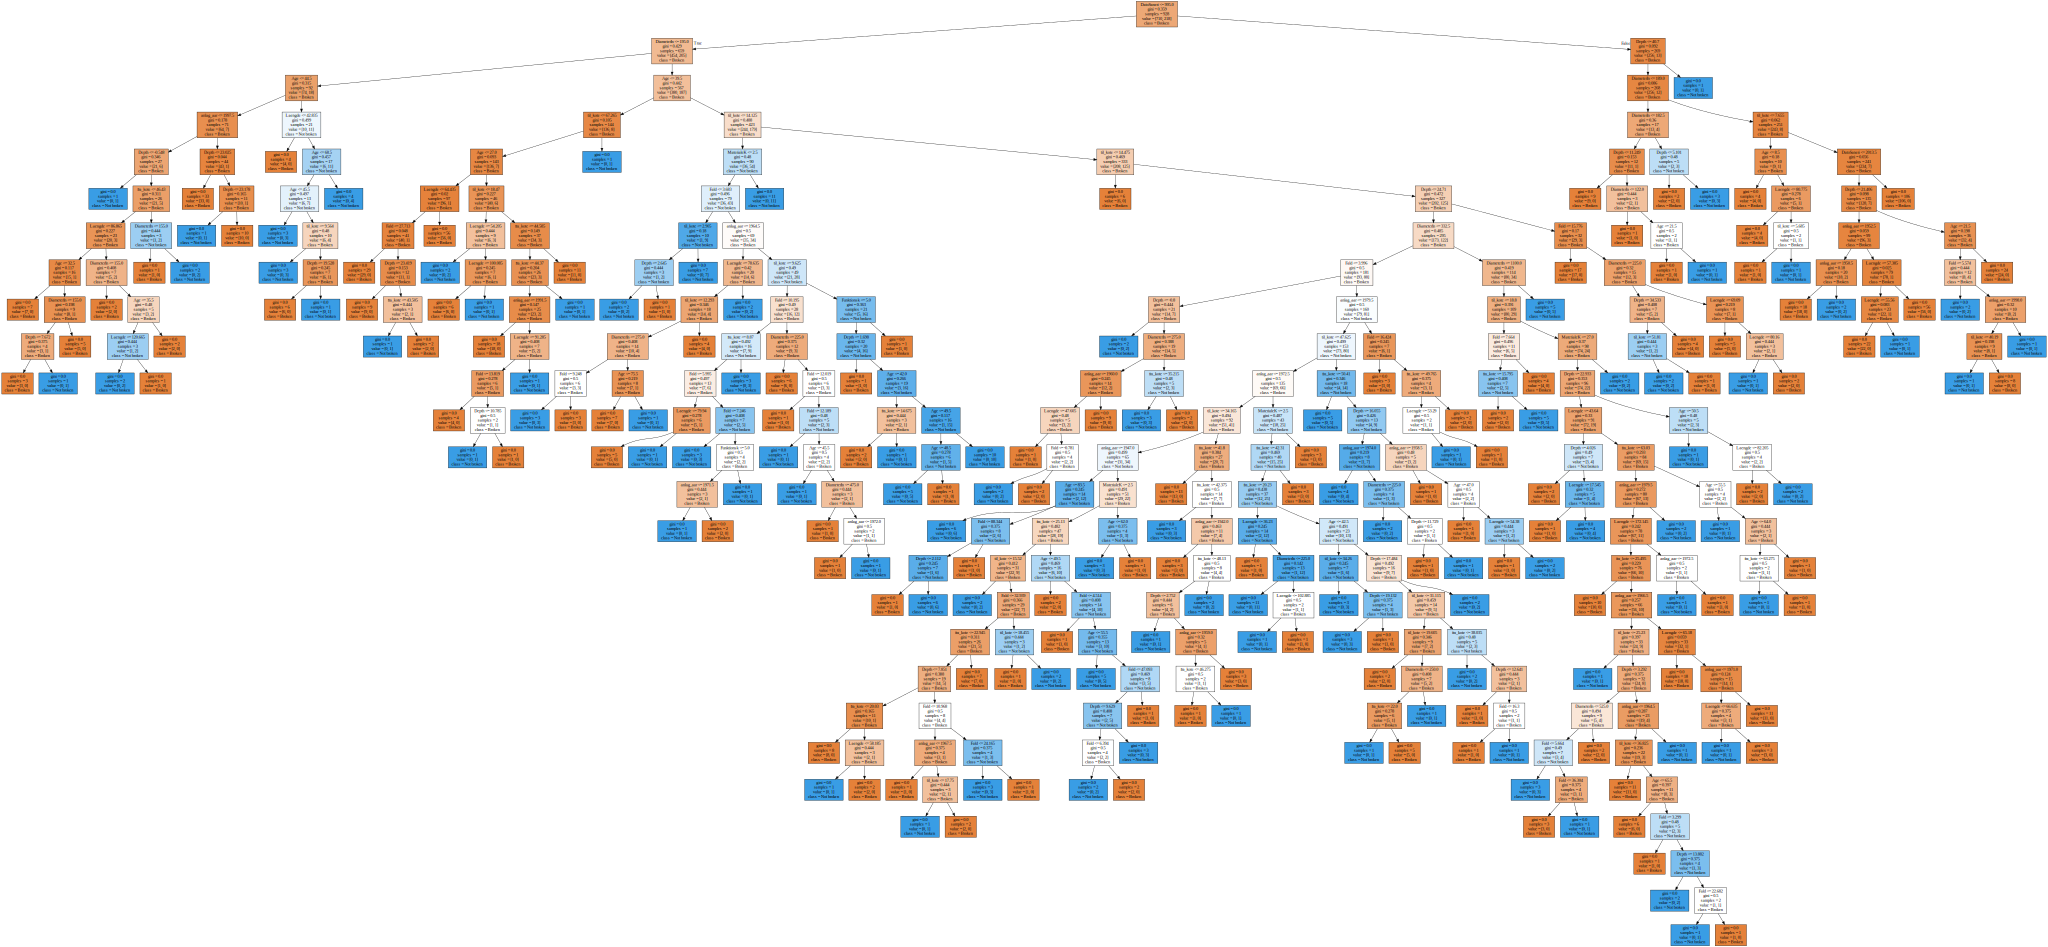

In [72]:
dot_data = export_graphviz(dec_tree, out_file=None,
                           class_names=["Broken","Not broken"],
                           feature_names= data_features.columns, 
                           filled=True)

graph = graphviz.Source(dot_data)
graph

In [ ]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"5,5!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

In [ ]:
def plot_feature_importances_pipes(model):
    n_features = data_features.shape[1]
    feature_names=["fra_kote","til_kote", "Laengde","Fald","DiameterIn","MaterialeK","anlag_aar","TransportK","Funktionsk","DatoSaneri","Age"]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_pipes(dec_tree)

# Tuning parameters with validation set split

In [73]:
# Divide the data into training, test and validation

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=43)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of validation set:{}".format(X_val.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:696
Size of validation set:232
Size of test set:310


In [74]:
best_score = 0

for max_depth in [3,4,5,6,7,8,9,10,20,30,40,50,60]:
    for criterion in ['gini', 'entropy']:
        for max_features in ['sqrt', 'log2','auto']:
             # Learn the model 
                    dec_tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
                    dec_tree.fit(X_train, y_train)
                        
                        # Evaluate the model
                    score = dec_tree.score(X_val, y_val)
                        
                         # If improvement, store score and parameter
                    if score>best_score:
                        best_score = score
                        best_max_depth = max_depth
                        best_max_features= max_features
                        best_criterion = criterion


# Build a model on the combine training and valiation data
dec_tree = DecisionTreeClassifier(max_depth= best_max_depth, max_features=best_max_features, criterion=best_criterion)
dec_tree.fit(X_trainval, y_trainval)

print("Best best_max_depth found: {}".format(best_max_depth))
print("Best best_max_features found: {}".format(best_max_features))
print("Best best_criterion found: {}".format(best_criterion))
print("Best score on validation set: {}".format(best_score))
print("Score on training/validation set: {}".format(dec_tree.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(dec_tree.score(X_test, y_test)))

Best best_max_depth found: 6
Best best_max_features found: auto
Best best_criterion found: entropy
Best score on validation set: 0.8189655172413793
Score on training/validation set: 0.8081896551724138
Score on test set: 0.7225806451612903


In [75]:
#Predict test data set.
y_pred = dec_tree.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       239
           1       0.40      0.41      0.40        71

    accuracy                           0.72       310
   macro avg       0.61      0.61      0.61       310
weighted avg       0.73      0.72      0.72       310



0.6121751429076551

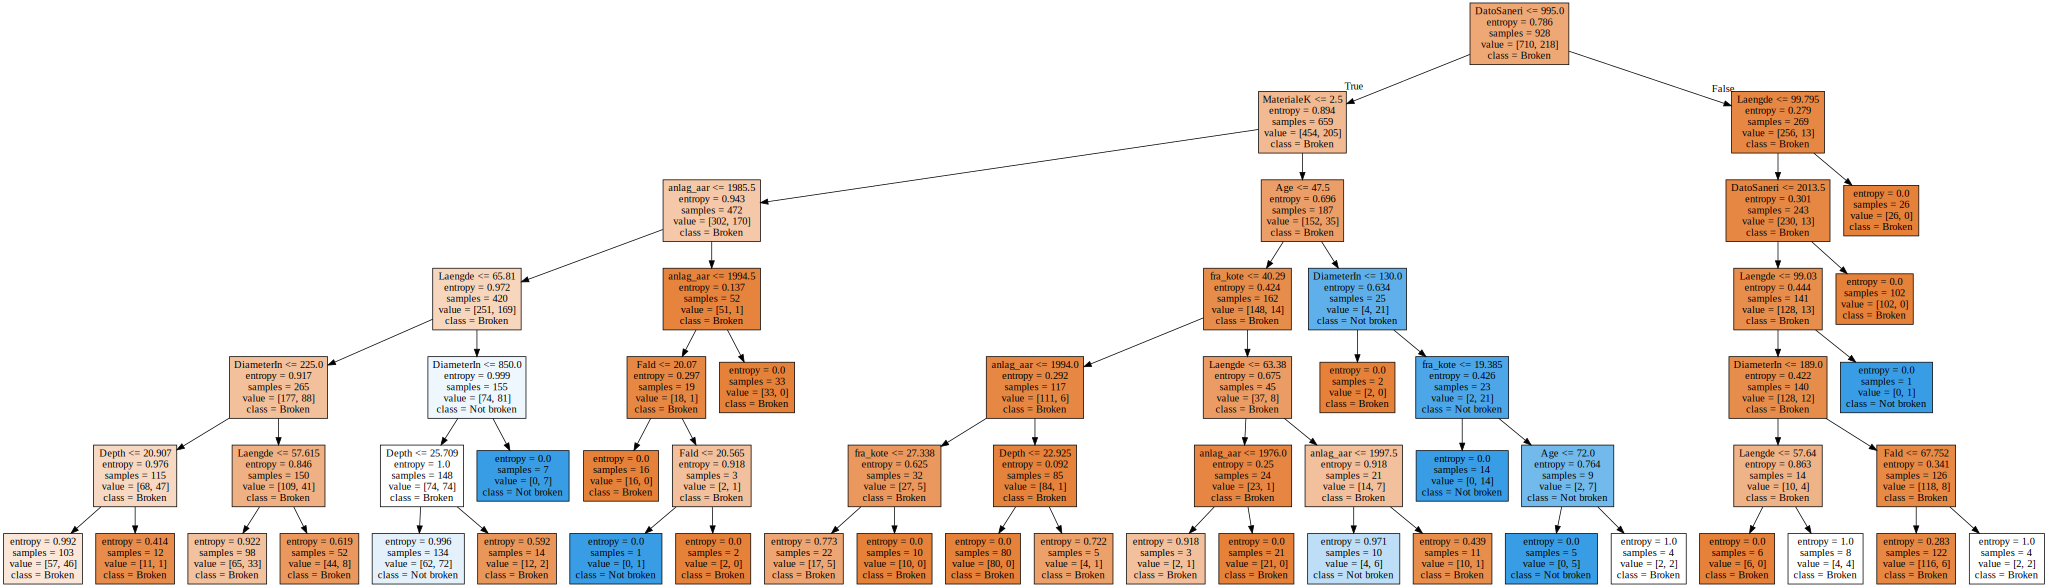

In [76]:
dot_data = export_graphviz(dec_tree, out_file=None,
                           class_names=["Broken","Not broken"],
                           feature_names= data_features.columns, 
                           filled=True)

graph = graphviz.Source(dot_data)
graph

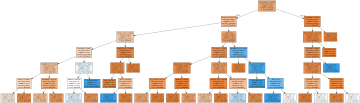

In [77]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"5,5!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

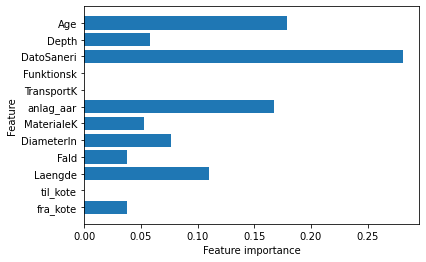

In [78]:
def plot_feature_importances_pipes(model):
    n_features = data_features.shape[1]
    feature_names= data_features.columns
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_pipes(dec_tree)

# Tuning parameters with cross validation

In [79]:
# Divide the data into training and test , no validation data

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:696
Size of test set:310


In [80]:
best_score = 0

for max_depth in [3,4,5,6,7,8,9,10,20,30,40,50,60]:
    for criterion in ['gini', 'entropy']:
        for max_features in ['sqrt', 'log2','auto']:
            # Learn the model 
            dec_tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        
            # Perform cross validation
            scores = cross_val_score(dec_tree, X_trainval, y_trainval, cv=5)
        
            # Compute the mean score
            score = scores.mean()
        
        
           # If improvement, store score and parameter
            if score>best_score:
                best_score = score
                best_max_depth = max_depth
                best_max_features= max_features
                best_criterion = criterion

# Build a model on the combine training and valiation data
dec_tree = DecisionTreeClassifier(max_depth= best_max_depth, max_features=best_max_features, criterion=best_criterion)
dec_tree.fit(X_trainval, y_trainval)

print("Best best_max_depth found: {}".format(best_max_depth))
print("Best best_max_features found: {}".format(best_max_features))
print("Best best_criterion found: {}".format(best_criterion))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(dec_tree.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(dec_tree.score(X_test, y_test)))

Best best_max_depth found: 7
Best best_max_features found: sqrt
Best best_criterion found: gini
Best average score: 0.7823830281894798
Score on training/validation set: 0.8405172413793104
Score on test set: 0.7612903225806451


In [81]:
#Predict test data set.
y_pred = dec_tree.predict(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       239
           1       0.46      0.23      0.30        71

    accuracy                           0.76       310
   macro avg       0.63      0.57      0.58       310
weighted avg       0.72      0.76      0.73       310



0.5729271023631327

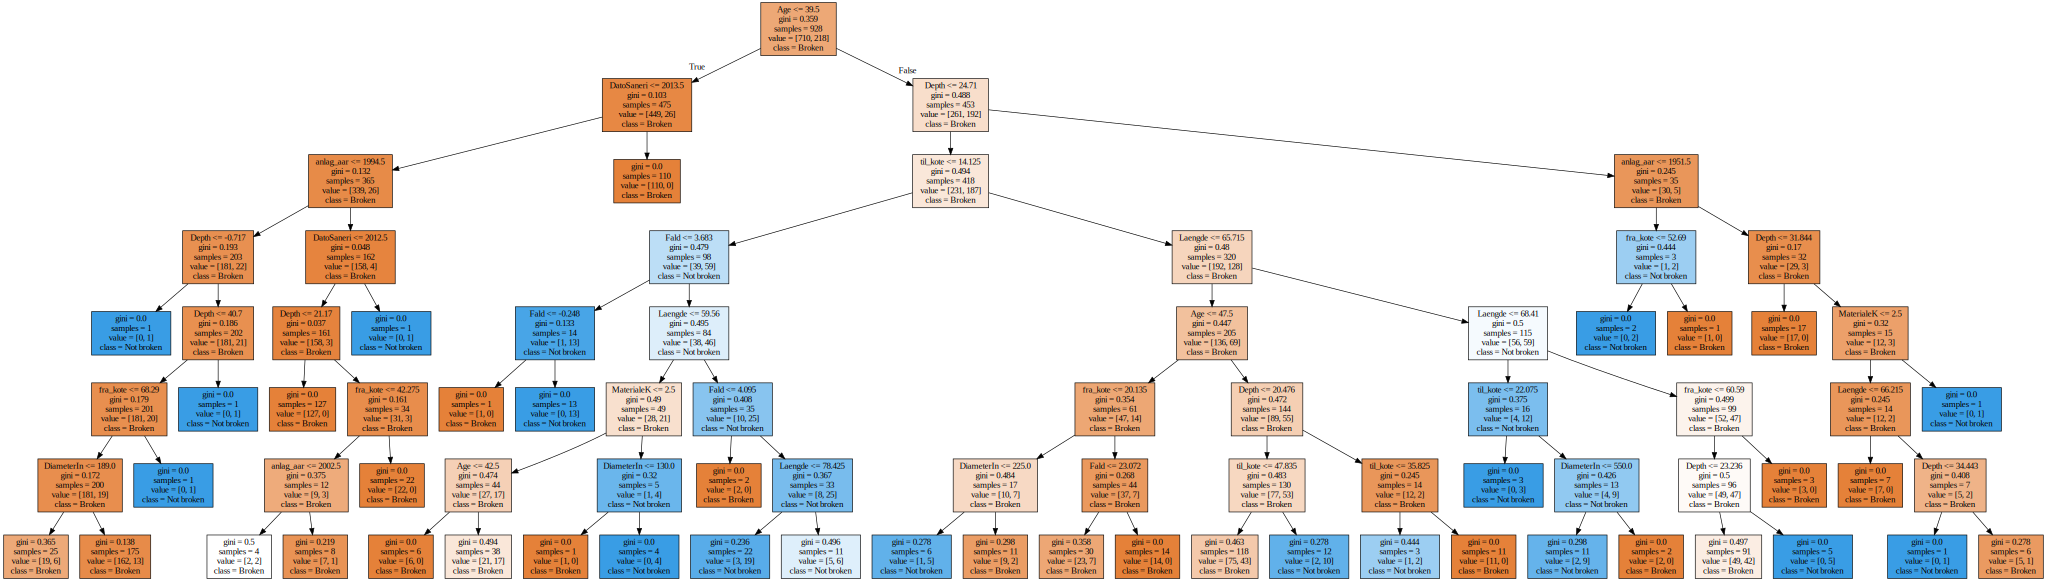

In [82]:
dot_data = export_graphviz(dec_tree, out_file=None,
                           class_names=["Broken","Not broken"],
                           feature_names= data_features.columns, 
                           filled=True)

graph = graphviz.Source(dot_data)
graph

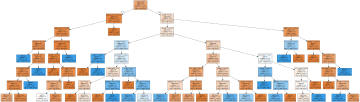

In [83]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"5,5!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

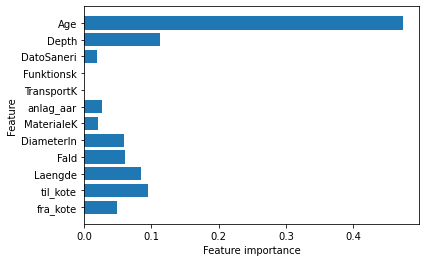

In [84]:
def plot_feature_importances_pipes(model):
    n_features = data_features.shape[1]
    feature_names= data_features.columns
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_pipes(dec_tree)

Confusion matrix:  
[[220  19]
 [ 55  16]]

Accuracy: 
0.7612903225806451

Precision: 
0.45714285714285713

Recall: 
0.22535211267605634

F1: 
0.3018867924528302
Area under curve: 
0.5729271023631327
[2 1 0]


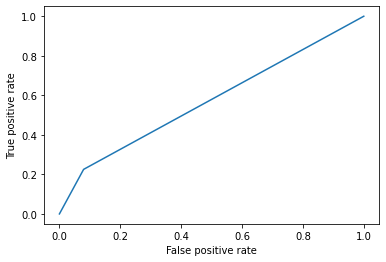

In [85]:
# check the model performance

#Predict test data set.
y_pred = dec_tree.predict(X_test)

print("Confusion matrix:  \n{}\n".format(confusion_matrix(y_test, y_pred)))
print("Accuracy: \n{}\n".format(dec_tree.score(X_test,y_test)))
print("Precision: \n{}\n".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: \n{}\n".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: \n{}".format(f1_score(y_test, y_pred,pos_label=1)))


#ROC curve
fpr,tpr,thresh = roc_curve(y_test,dec_tree.predict(X_test))
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("Area under curve: \n{}".format(roc_auc_score(y_test,dec_tree.predict(X_test))) )
print(thresh)



[0 1]


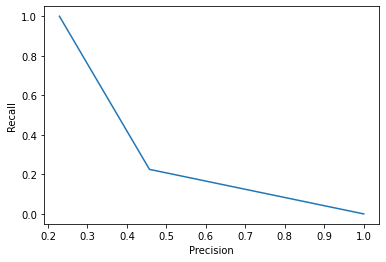

In [86]:
# precision recall curve
prec,rec,thresh1 = precision_recall_curve(y_test,dec_tree.predict(X_test))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(prec,rec)
print(thresh1)